# Wikidata information

In [1]:
import json
import matplotlib as mpl                            # font of plot
import matplotlib.pyplot as plt      
import numpy as np
import requests                                     # for making HTTP requests
from matplotlib.font_manager import fontManager    
from collections import Counter                     # Import the Counter class for counting elements

path = "../datasets.jsonl"                          # Define the path to the JSON Lines file
font_path = "../TaipeiSansTCBeta-Regular.ttf"       # Define the path to a custom font

fontManager.addfont(font_path)
mpl.rc('font', family='Taipei Sans TC Beta')

o_dataset = []                                      # Create an empty list to store dataset entries
with open(path, "r") as f:                    
    line_count = 0
    for line in f:
      line_count += 1
    f.seek(0)                                      
    for i in range(line_count):
        line = f.readline()
        data = json.loads(line)
        o_dataset.append(data)
        
print(o_dataset[:2])                                # Print the first two entries in the dataset

[{'author': '國立臺南大學流域生態環境保育研究中心', 'author_email': None, 'contact_email': '', 'contact_person': '', 'creator_user_id': 'b921b80f-2fef-4551-a2b3-5b252a84ec1d', 'data_type': ['doc', 'network'], 'end_time': '2023-09', 'groups': [], 'id': 'f4159f57-d620-4356-982a-5fa6d3501d9d', 'isopen': True, 'keywords': [], 'language': [], 'license_id': 'pd', 'license_title': 'Public Domain', 'license_url': 'https://creativecommons.org/publicdomain/mark/1.0/', 'maintainer': None, 'maintainer_email': None, 'metadata_created': '2022-12-31T01:52:30.320236', 'metadata_modified': '2023-08-25T03:34:40.265114', 'name': 'l15-l18', 'notes': '本工程施工期程為111/8/20～112/8/19(預計)，由金主營造工程股份有限公司委託本中心生態背景人員進行①檢閱施工廠商填查「生態保育措施自主檢查表*」內容並協助上傳至本資料集，以落實資訊公開之即時性；②第一級品管外部稽核三次(預計112年2-4月實施)，檢查生態保育措施執行情形。', 'num_resources': 19, 'num_tags': 2, 'organization': None, 'private': False, 'process_step': '', 'relationships_as_object': [], 'relationships_as_subject': [], 'remarks': '', 'resources': [{'cache_last_updated': None, 'cache_url': No

## 確認關鍵字是否在wikidata中

In [2]:
def find_word(list1): 
  word_list = []
  for i in list1:
    endpoint_url = f"https://www.wikidata.org/wiki/Special:EntityData/{i}.json"  #api for wikidata searching
    response = requests.get(endpoint_url)
    if response.status_code == 200:
        data = response.json()
        # The label (name) of the entity will be available in the 'labels' section of the JSON response
        label = data['entities'][i]['labels']['en']['value']
        word_list.append(label)
    else:
        print("Error occurred:", response.text)
  return word_list


## wikidata keywords
keywords count by catagory

In [3]:
keywords = []

for i in o_dataset:
  if i.get('keywords') is not None:      # assure keywords column exists
    for j in i['keywords']:
      keywords.append(j)
      
keywords_count = Counter(keywords)       
mostuse_keywords = keywords_count.most_common(10)  

keywords_name = [i[0] for i in mostuse_keywords]
keywords_value = [i[1] for i in mostuse_keywords]


word_list = find_word(keywords_name)     
key_value = [i[1] for i in mostuse_keywords]
wikidata = []

for i in range(len(word_list)):
  wikidata.append((word_list[i],keywords_value[i]))
print(wikidata)

concat_word = []   
for i in word_list:
  concat_word.append(i[:20])  # limit the length of names


[('Taijiang Inner Sea', 51), ('Changhua County Government', 49), ('drainage system', 48), ('Taiwan', 46), ('unmanned aerial vehicle', 46), ('Forward-looking foundation construction plans in Taiwan', 34), ('Tainan', 31), ('Web Map Tile Service', 31), ('thesis', 27), ('historical atlas', 24)]


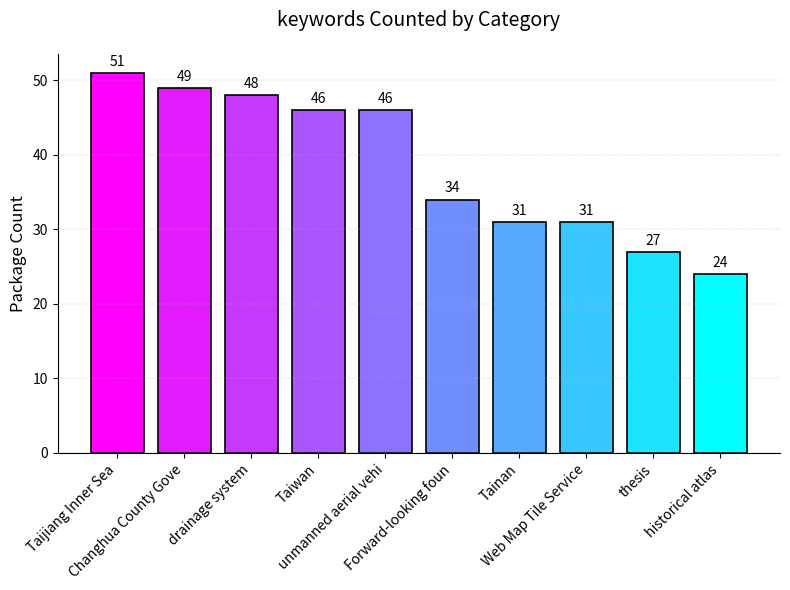

In [4]:
plt.figure(figsize=(8, 6))  # Adjust the figure size
ax = plt.gca()
colors = plt.cm.cool(np.linspace(1, 0, len(concat_word)))
# Create the bar plot
bars = plt.bar(concat_word, keywords_value, color=colors, edgecolor='black', linewidth=1.2)


# Add data labels on the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom', fontsize=10)  # Adjust label position and fontsize
plt.ylabel('Package Count', fontsize=12)
plt.title('keywords Counted by Category', fontsize=14, pad=20)

plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate and adjust fontsize of x tick labels
plt.yticks(fontsize=10)  # Adjust fontsize of y tick labels

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a grid for better readability
ax.yaxis.grid(True, linestyle='--', linewidth=0.3, alpha=0.7) # alpha for the transparence

plt.tight_layout()
plt.show()

## tag與wikidata關鍵字的關係

比較最常用的tag是否有在wikidata中出現，tag會有中文字要額外處理

In [5]:
from wikidataintegrator import wdi_core
import requests

# Function to determine the type of word based on its ASCII code
def type_word(word):
    ascii_code = ord(word)
    if (65 <= ascii_code <= 90 or 97 <= ascii_code <= 122):
        return "En"   # English alphabet
    elif (48 <= ascii_code <= 57):
        return "num"  # Numeric digit
    return "CH"       # Chinese character

# Function to check if a tag exists in Wikidata
def is_tag_in_wikidata(tag):
    sparql_query = []
    if type_word(tag[0]) == "En":
        sparql_query = f'SELECT ?item WHERE {{ ?item rdfs:label "{tag}"@en }}'
    elif type_word(tag[0]) == "CH":
        sparql_query = f'SELECT ?item WHERE {{ ?item rdfs:label "{tag}"@zh. }}'
    else:
        sparql_query = f'''
            SELECT ?item WHERE {{
                {{ ?item rdfs:label "{tag}"@en. }}
                UNION
                {{ ?item rdfs:label "{tag}"@zh-TW. }} }} '''

    # Execute the SPARQL query using the wikidataintegrator library
    result = wdi_core.WDItemEngine.execute_sparql_query(sparql_query)

    if result['results']['bindings']:
        return True
    else:
        return False

# API URL to retrieve most used tags in depositar
url = "http://data.depositar.io/api/3/action/package_search?facet.field=[%22tags%22]&facet.limit=10"
package_list = requests.get(url).json()

# Extract tag data from the package list
tag_number = package_list['result']['facets']['tags']
tag_list = list(tag_number.items())
tag_list_keys = list(tag_number.keys())

# Filter tags that exist in Wikidata using the is_tag_in_wikidata function
filter_tags = [tag for tag in tag_number if is_tag_in_wikidata(tag)]

# Function to compare two lists and find intersections and differences
def compare(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    common_set = set1.intersection(set2)
    diff_set = set1.difference(set2)

    return common_set, diff_set

# Compare the original tag list with the filtered tag list
intersect, differ = compare(tag_list_keys, filter_tags)

# Print the results
print("重複出現", intersect)  # Tags that appear both in the original list and in Wikidata
print("需要補充", differ)     # Tags that are in the original list but not in Wikidata


重複出現 {'UAS', '高雄市', 'UAV', '論文', '台江國家公園'}
需要補充 {'LTSER', '生態檢核', 'playaround workshop', '水與安全計畫', '前瞻水環境建設'}
